In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-04-27 13:42:55 (KST = GMT+0900) 


0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.7.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.23.2
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8438
8 photutils  1.6.1.dev103+gad22185f
9 version_information 1.0.4


In [2]:

# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path

import numpy as np

from astropy import units as u
from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord

from astroquery.gaia import Gaia
from astroquery.mast import Catalogs
Gaia.ROW_LIMIT = -1  # no limit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.aperture import (CircularAperture, CircularAnnulus, 
                                aperture_photometry, ApertureStats)
from photutils.detection import DAOStarFinder

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
print(ccd.wcs)

pix_scale = 0.4*u.arcsec

center_xy = np.array(ccd.shape)/2
center_radec = ccd.wcs.wcs_pix2world(*center_xy, 0)
center_coo = SkyCoord(*center_radec, unit='deg')

width, height = np.array(ccd.shape)*pix_scale

print("\nCoordinate of the center of the image:\n", center_coo)

fov_radius = np.sqrt((np.array(ccd.shape)**2).sum())/2 * pix_scale

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 204.8640878996  -8.991494826739  
CRPIX : -4068.090526349  5085.76507007  
PC1_1 PC1_2  : -0.0001096993846665  -1.593373136163e-06  
PC2_1 PC2_2  : -2.91576786403e-07  0.0001095957848141  
CDELT : 1.0  1.0  
NAXIS : 999  999

Coordinate of the center of the image:
 <SkyCoord (ICRS): (ra, dec) in deg
    (204.36178211, -9.49675272)>


/Users/ysbach/miniforge3/lib/python3.10/site-packages/astropy/wcs/wcs.py:3064: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


In [4]:
# =====
# If you want to use MAST, only DR2 is available as of 2023-04-26. 
# You can uncomment q_gaia line.
# Gaia DR2 needs `version=2`
# q_gaia = Catalogs.query_region(center_coo, radius=fov_radius, catalog="Gaia", version=2) 
# =====

# Set default table as DR3 and GAIA_SOURCE.
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
q_gaia = Gaia.query_object_async(coordinate=center_coo, width=width, height=height)

# PS1 DR2 needs `data_release="dr2"`.
q_ps = Catalogs.query_region(center_coo, radius=fov_radius, catalog="Panstarrs", 
                             data_release="dr2", table="mean")
# Change some column names for convenience.
q_ps["raMean"].name = "ra"
q_ps["decMean"].name = "dec"
q_ps["gMeanPSFMag"].name = "g"
q_ps["rMeanPSFMag"].name = "r"

print("Number of results:",len(q_gaia))
print("Number of results:",len(q_ps))

INFO: Query finished. [astroquery.utils.tap.core]


Number of results: 75
Number of results: 5907


In [5]:
print("Number of columns in Gaia, PS1:", len(q_gaia.colnames), len(q_ps.colnames))

Number of columns in Gaia, PS1: 153 125


In [6]:
coef = np.array([-0.02704, 0.1425, -0.2156, 0.01426])
rmse = 0.03017
color = q_gaia["bp_rp"]

# Add useful columns
q_gaia["bp_snr"] = 1/q_gaia["phot_bp_mean_flux_over_error"]
q_gaia["rp_snr"] = 1/q_gaia["phot_rp_mean_flux_over_error"]
q_gaia["g_snr"] = 1/q_gaia["phot_g_mean_flux_over_error"]

# Calculate color error
q_gaia["dC"] = 2.5/np.log(10)*np.sqrt((q_gaia["rp_snr"])**2 + (q_gaia["bp_snr"])**2)

# Calculate V-mag and error
q_gaia["V"] = (
    q_gaia["phot_g_mean_mag"]
    + coef[0] + coef[1]*color + coef[2]*color**2 + coef[3]*color**3
)
q_gaia["dV"] = np.sqrt(
    2.5/np.log(10)*q_gaia["g_snr"]**2
    + (coef[1] + 2*coef[2]*color + 3*coef[3]*color**2)**2*q_gaia["dC"]**2
    + rmse**2
)

# Only select stars with good color
mask = (-0.5 < color) & (color < 5)
q1 = q_gaia["ra", "dec", "bp_rp", "g_snr", "bp_snr", "rp_snr", "dC", "V", "dV"][mask]

# Calculate x, y position
coo = SkyCoord(q1["ra"], q1["dec"], unit='deg')
q1["x"], q1["y"] = ccd.wcs.wcs_world2pix(coo.ra, coo.dec, 0)

# Remove stars outside the image
q1 = q1[(q1["x"] > 10) & (q1["x"] < ccd.shape[1]-10) 
        & (q1["y"] > 10) & (q1["y"] < ccd.shape[0]-10)]

# print
print(f"Total {len(q1)} stars")
q1.round(3)
q1


Total 65 stars


ra,dec,bp_rp,g_snr,bp_snr,rp_snr,dC,V,dV,x,y
deg,deg,mag,,,,,,,,
float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64
204.352,-9.504,0.732,0.016,0.139,0.188,0.254,20.859,0.051,586.313,435.758
204.373,-9.505,2.855,0.002,0.033,0.004,0.036,16.681,0.041,399.077,428.649
204.373,-9.505,2.871,0.006,0.016,0.01,0.02,16.781,0.034,399.015,427.491
204.373,-9.505,2.748,0.005,0.245,0.087,0.282,19.131,0.205,403.101,420.853
204.35,-9.508,1.956,0.004,0.13,0.051,0.152,19.712,0.087,607.765,395.122
204.378,-9.502,0.28,0.003,0.035,0.058,0.073,19.432,0.03,355.88,450.611
204.34,-9.486,2.01,0.003,0.092,0.032,0.106,19.125,0.066,692.754,596.982
204.343,-9.514,2.116,0.005,0.116,0.037,0.132,19.665,0.082,669.384,345.025


In [7]:
# drop stars with unknown magnitudes
q_ps = q_ps.to_pandas().dropna(subset=["g", "r"])

# Calculate V and R
q_ps["V"] = 0.006 + 0.474*q_ps["g"] + 0.526*q_ps["r"]
q_ps["R"] = -0.138 - 0.131*q_ps["g"] + 1.131*q_ps["r"]
q_ps["dV"] = np.sqrt(
    0.474**2*q_ps["gMeanPSFMagErr"]**2 
    + 0.526**2*q_ps["rMeanPSFMagErr"]**2 + 0.012**2
)
q_ps["dR"] = np.sqrt(
    0.131**2*q_ps["gMeanPSFMagErr"]**2
    + 1.131**2*q_ps["rMeanPSFMagErr"]**2 + 0.015**2
)

# Select only important columns
q2 = q_ps[["ra", "dec", "g", "r", "V", "R", "dV", "dR"]].copy().reset_index(drop=True)

# Select only brighter than 22 mag
q2 = q2[(q2["V"] < 22) & (q2["R"] < 22)].copy().reset_index(drop=True)

# Calculate x, y position
coo = SkyCoord(q2["ra"], q2["dec"], unit='deg')
q2["x"], q2["y"] = ccd.wcs.wcs_world2pix(coo.ra, coo.dec, 0)

# Remove stars outside the image
q2 = q2[(q2["x"] > 10) & (q2["x"] < ccd.shape[1]-10) 
        & (q2["y"] > 10) & (q2["y"] < ccd.shape[0]-10)]

# print
print(f"Total {len(q2)} stars")
q2.round(3)
q2

Total 126 stars


,ra,dec,g,r,V,R,dV,dR,x,y
2,204.409944,-9.450248,21.397699,20.540300,20.952707,20.289981,0.061518,0.117752,63.384671,920.312548
6,204.345158,-9.518216,22.233601,21.176100,21.683355,20.899567,0.108760,0.104415,650.897766,304.768236
7,204.354596,-9.520246,21.534100,21.073400,21.297772,20.875049,0.036315,0.047813,566.509401,286.142286
8,204.354704,-9.520213,21.246901,21.009100,21.127817,20.839948,0.058233,0.119927,565.543487,286.445281
9,204.376820,-9.523145,18.553301,17.914900,18.223502,17.693269,0.013901,0.020472,367.682141,259.376768
...,...,...,...,...,...,...,...,...,...,...
183,204.391725,-9.449751,21.913401,19.827200,20.822059,19.415908,0.114143,0.057990,226.350935,925.358571
184,204.391725,-9.449731,20.910900,19.654699,20.256139,19.352137,0.023311,0.034164,226.344244,925.539059
185,204.322624,-9.524781,18.504400,17.985399,18.237406,17.779410,0.012597,0.016538,853.773794,245.408823
186,204.413848,-9.503995,22.077999,21.634600,21.850771,21.438514,0.109889,0.135453,34.077485,432.497826


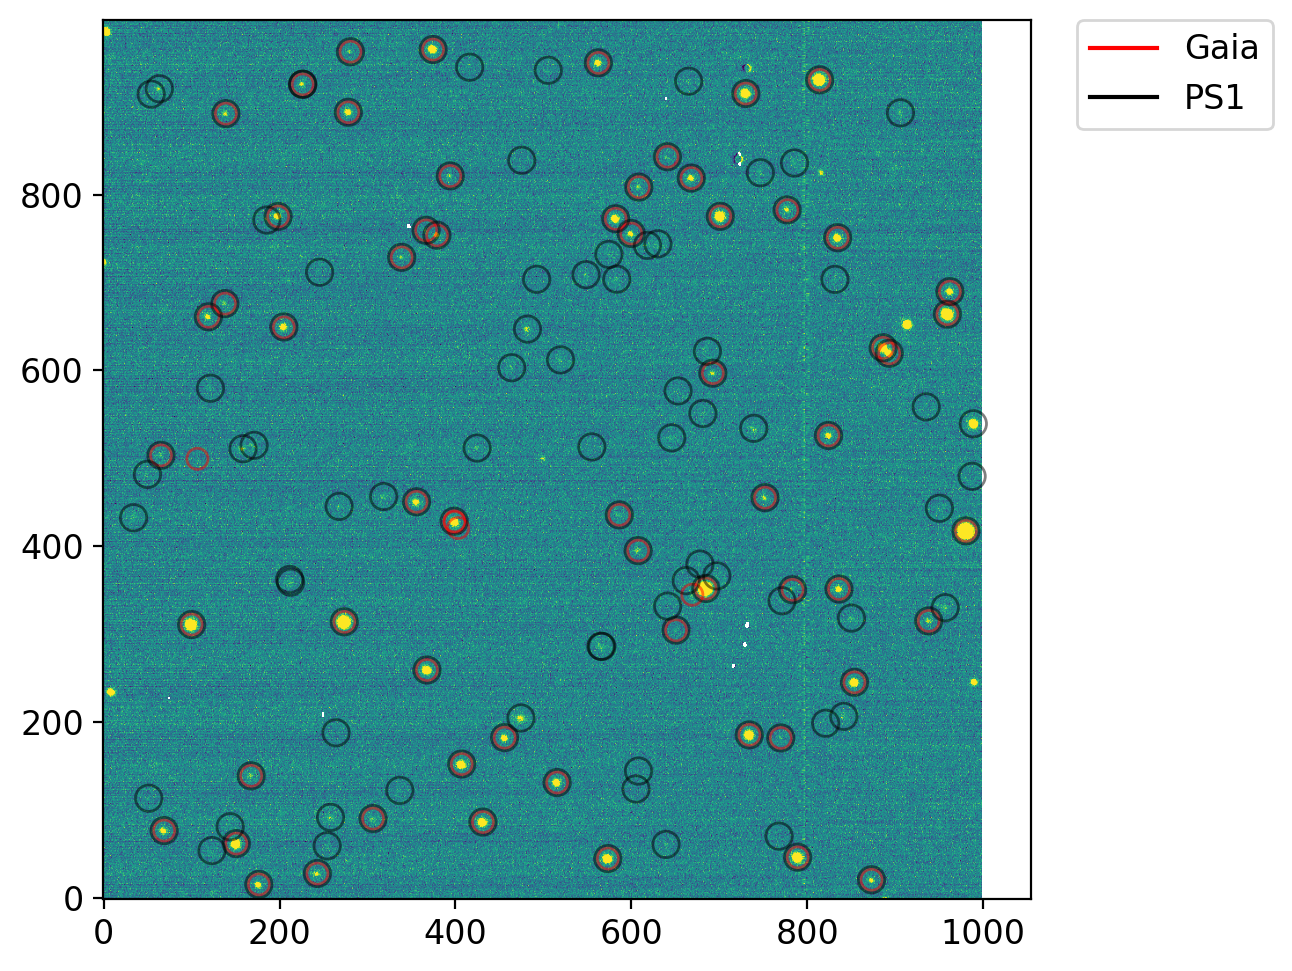

In [8]:
aps1 = CircularAperture(np.array([q1["x"], q1["y"]]).T, r=12)
aps2 = CircularAperture(np.array([q2["x"], q2["y"]]).T, r=15)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, ccd, zscale=True)
aps1.plot(color='r', lw=1, alpha=0.5, ax=axs)
aps2.plot(color='k', lw=1, alpha=0.5, ax=axs)

for c, l in zip("rk", ["Gaia", "PS1"]):
    axs.plot(np.nan, np.nan, f"{c}", label=l)
axs.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show();

In [9]:
ccd.header["DATE-OBS"]

'2018-04-13T21:30:26'

In [10]:
allfits

[PosixPath('../../Tutorial_Data/20180413SAAO_p4179_010449.fits'),
 PosixPath('../../Tutorial_Data/20180413SAAO_p4179_010451.fits'),
 PosixPath('../../Tutorial_Data/20180413SAAO_p4179_010453.fits'),
 PosixPath('../../Tutorial_Data/20180413SAAO_p4179_010455.fits'),
 PosixPath('../../Tutorial_Data/20180413SAAO_p4179_010457.fits'),
 PosixPath('../../Tutorial_Data/20180413SAAO_p4179_010459.fits'),
 PosixPath('../../Tutorial_Data/20180413SAAO_p4179_010461.fits')]